# Selecting Praesepe members and compiling data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [2]:
douglas = pd.read_csv("data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [3]:
prots = []
for p in douglas.Prot1.values:
    if p == "     ":
        prots.append(0.)
    else:
        prots.append(float(p))
douglas["prot"] = np.array(prots)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [4]:
with fits.open('data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)

Calculate uncertainties on Gaia mag, Gaia BP and Gaia RP.

In [5]:
def color_err(c):
    c_err = np.zeros(len(c))
    bright = c < 13
    medium = (13 < c) * (c < 17)
    faint = 17 <= c
    c_err[bright] = np.ones(len(c_err[bright]))*.002
    c_err[medium] = np.ones(len(c_err[medium]))*.01
    c_err[faint] = np.ones(len(c_err[faint]))*.2
    return c_err


def photometric_noise(G, bp, rp):
    G_err = np.zeros(len(G))
    bright = G < 13
    medium = (13 < G) * (G < 17)
    faint = 17 <= G
    G_err[bright] = np.ones(len(G_err[bright]))*.0003
    G_err[medium] = np.ones(len(G_err[medium]))*.002
    G_err[faint] = np.ones(len(G_err[faint]))*.01

    bp_err = color_err(bp)
    rp_err = color_err(rp)
    
    parallax_err = np.zeros(len(G))
    bright = G < 15
    medium = (15 < G) * (G < 17)
    faint = (17 < G) * (G < 20)
    ultra_faint = 21 <= G
    parallax_err[bright] = .03  # milliarcseconds
    parallax_err[medium] = .1
    parallax_err[faint] = .7
    parallax_err[ultra_faint] = 2
    
    return G_err, bp_err, rp_err, parallax_err

c5_mask = bedell.k2_campaign_str.values == "5"
G_err, bp_err, rp_err, _ = photometric_noise(bedell.phot_g_mean_mag.values[c5_mask],
                                             bedell.phot_bp_mean_mag.values[c5_mask],
                                             bedell.phot_rp_mean_mag.values[c5_mask])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


In [11]:
c5 = pd.read_csv("data/c5_gaia.csv")
c5["G_err"] = G_err
c5["BP_err"] = bp_err
c5["RP_err"] = rp_err

Text(0, 0.5, 'Dec')

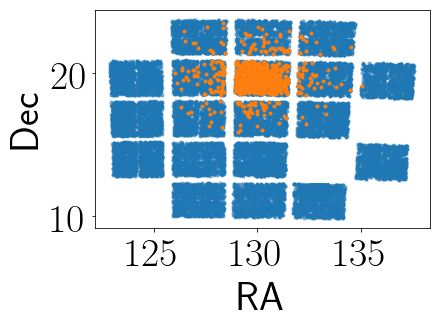

In [12]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [13]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 13) (794, 29) (757, 41)


Text(0, 0.5, 'Dec')

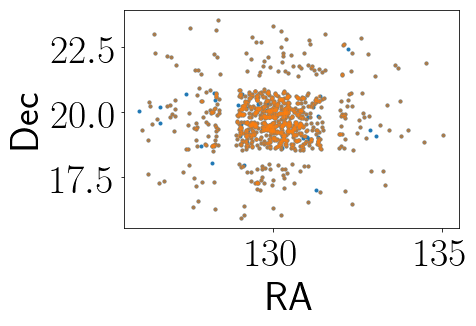

In [14]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

Save data file.

In [15]:
# All praesepe data without non-measurements
m = df.prot.values > 0.
df = df.iloc[m]
df.to_csv("data/praesepe.csv")

Find the visual binaries

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


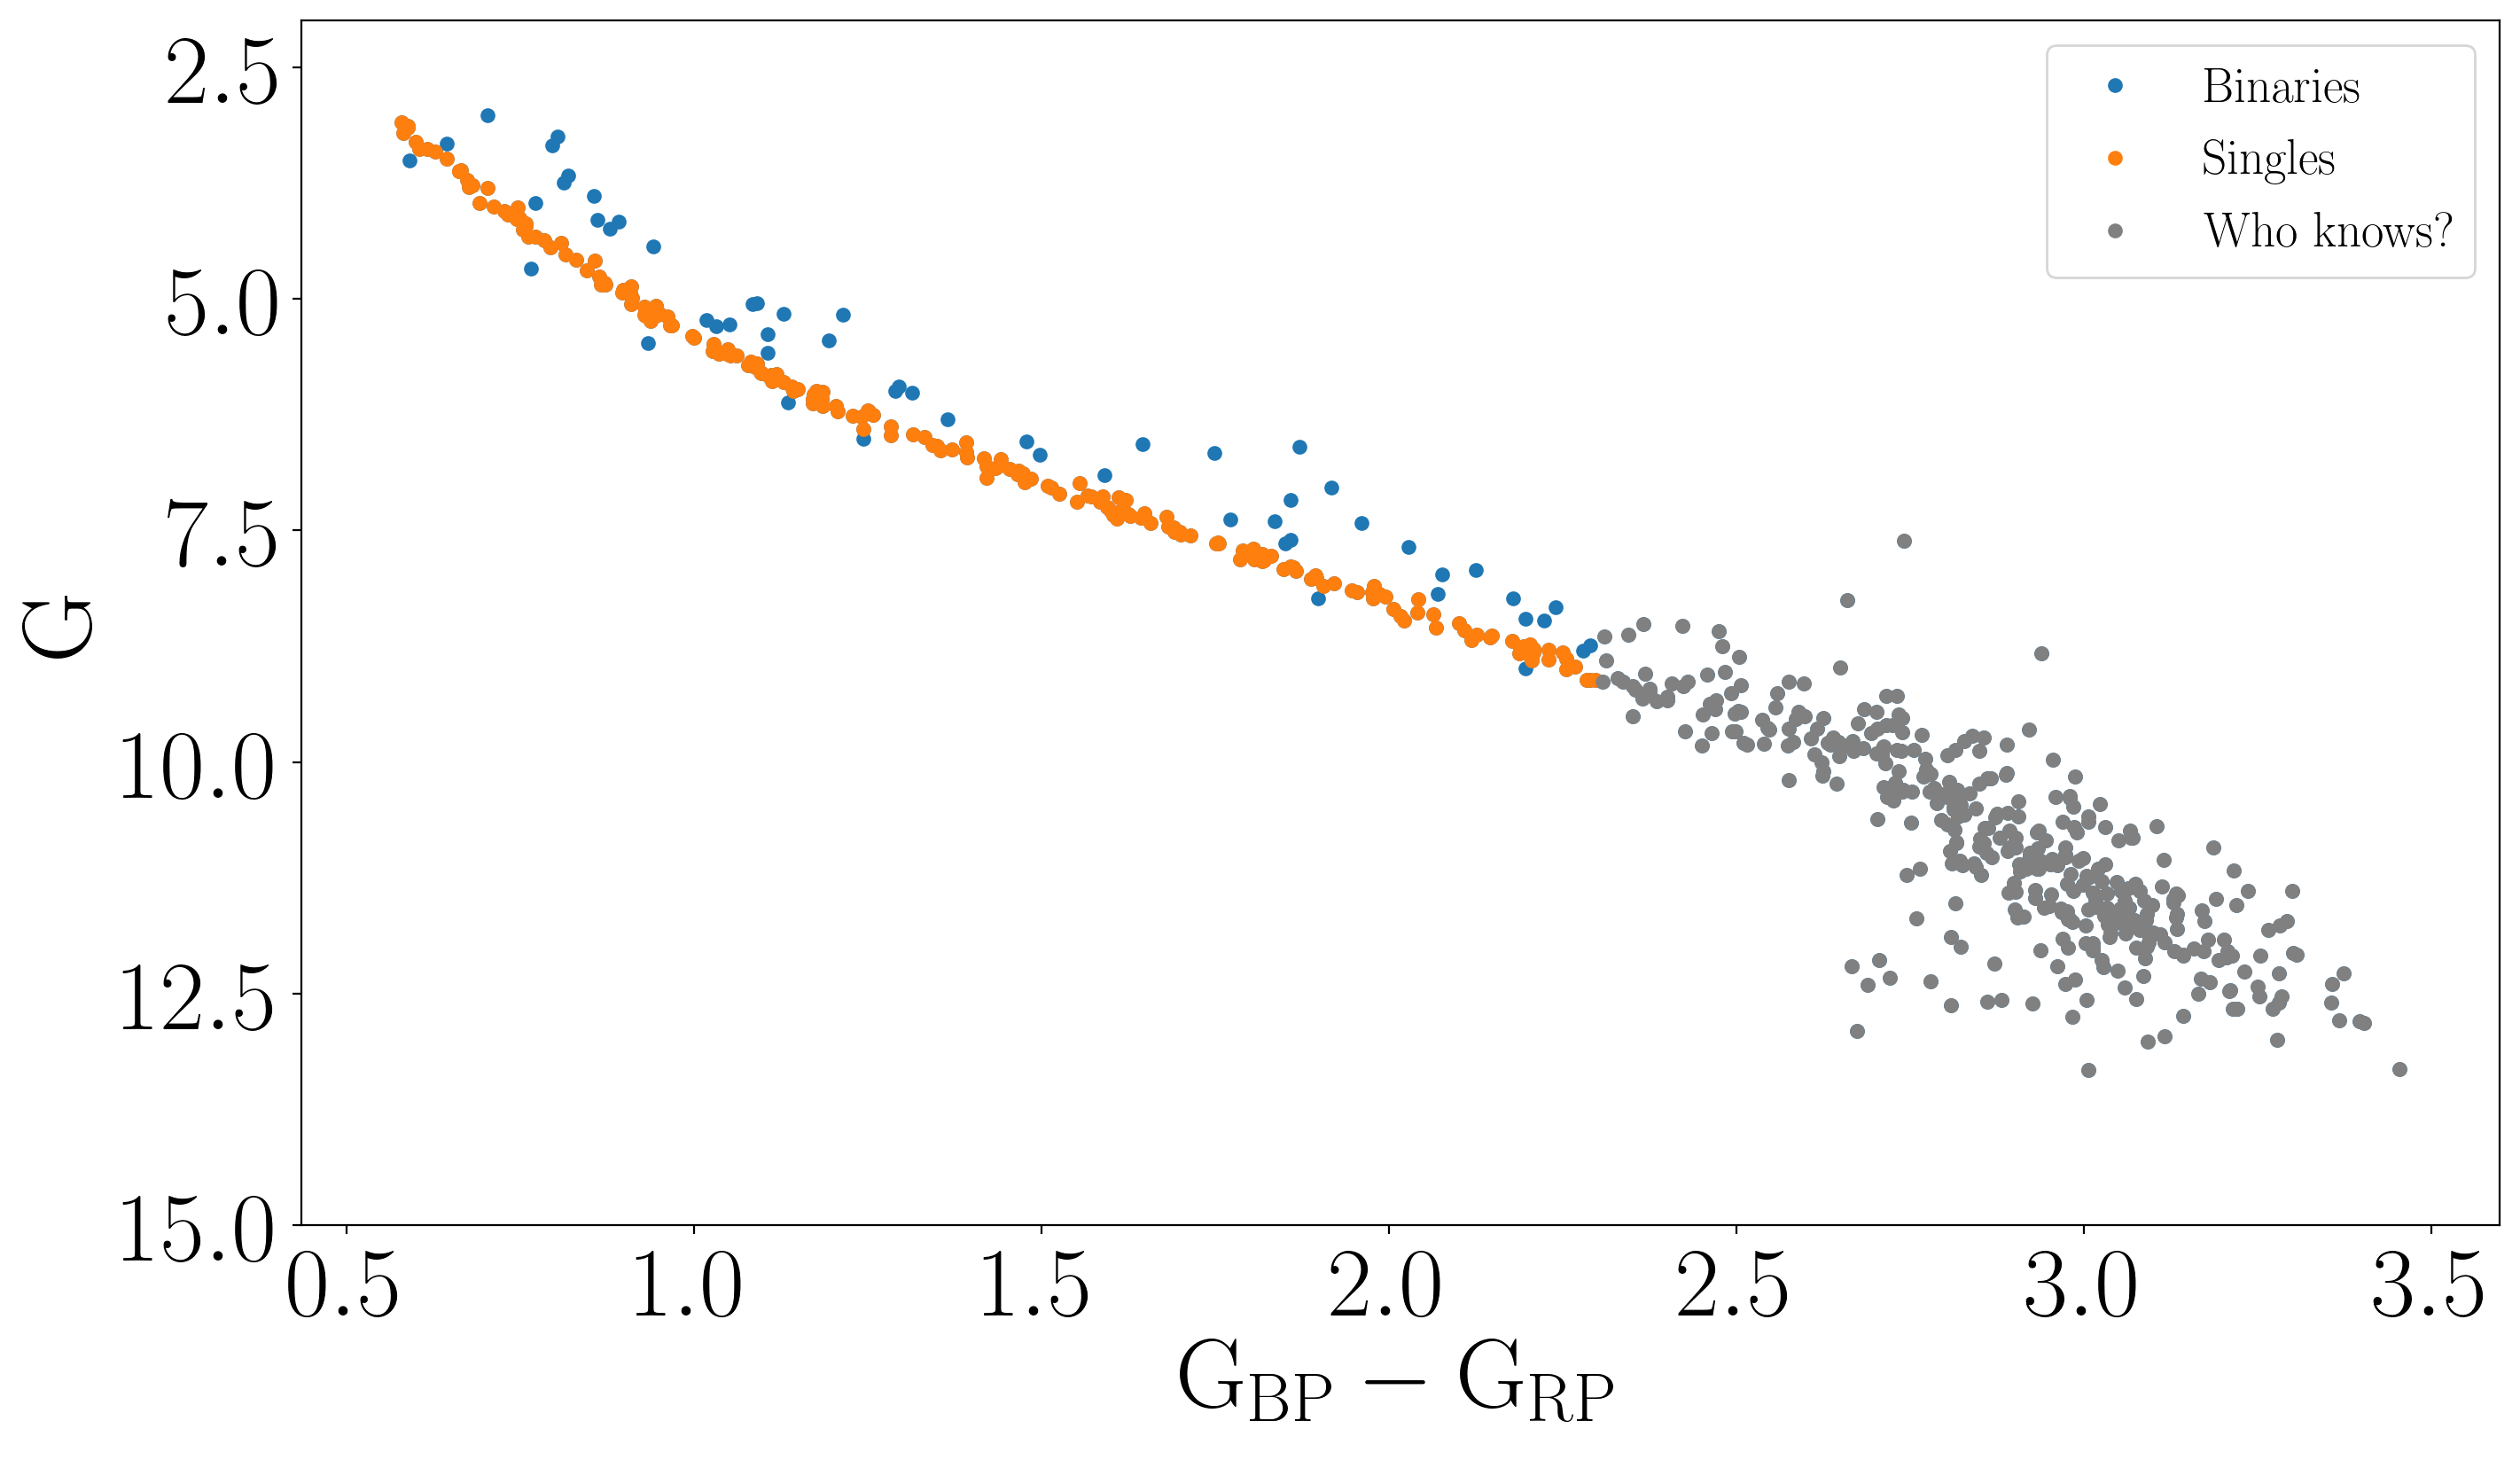

In [35]:
import scipy.optimize as spo
pr = df*1

def abs_mag(G, D):
    return - 5*np.log10(D) + 5 + G

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(y - model(p, x))**2/yerr**2)

def clip(x, y, yerr):
    pinit = np.ones(5)
    results = spo.minimize(nll, pinit, args=(x, y, yerr))
    p = results.x

    inds = np.arange(len(x))
    for i in range(10):
        results = spo.minimize(nll, p, args=(x, y, yerr));
        p = results.x
        std = np.std(y - model(p, x))
        m = abs(y - model(p, x)) > 3*std
        x, y, yerr = x[~m], y[~m], yerr[~m]
        inds = inds[~m]
    return x, y, yerr, p, inds

cool = pr.bp.values - pr.rp.values < 2.3

abs_G = abs_mag(pr.G.values, (1./pr.parallax.values)*1e3)
_x, _y, _yerr, _p, _inds = clip(pr.bp.values[cool]-pr.rp.values[cool],
                                abs_G[cool], np.ones(len(abs_G[cool]))*.001)

binary_flag = np.zeros(len(pr.G.values[cool]), dtype=bool) # binaries
binary_flag[_inds] = np.ones(len(binary_flag[_inds]), dtype=bool) # non-binaries

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(pr.bp.values-pr.rp.values, abs_G, ".", ms=10, label="$\mathrm{Binaries}$")
plt.plot(_x, _y, ".", ms=10, label="$\mathrm{Singles}$")
plt.plot(pr.bp.values[~cool]-pr.rp.values[~cool], abs_G[~cool], ".", ms=10, color=".5", 
         label="$\mathrm{Who~knows?}$", zorder=3)
plt.ylim(15, 2)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{G}$");
plt.legend()

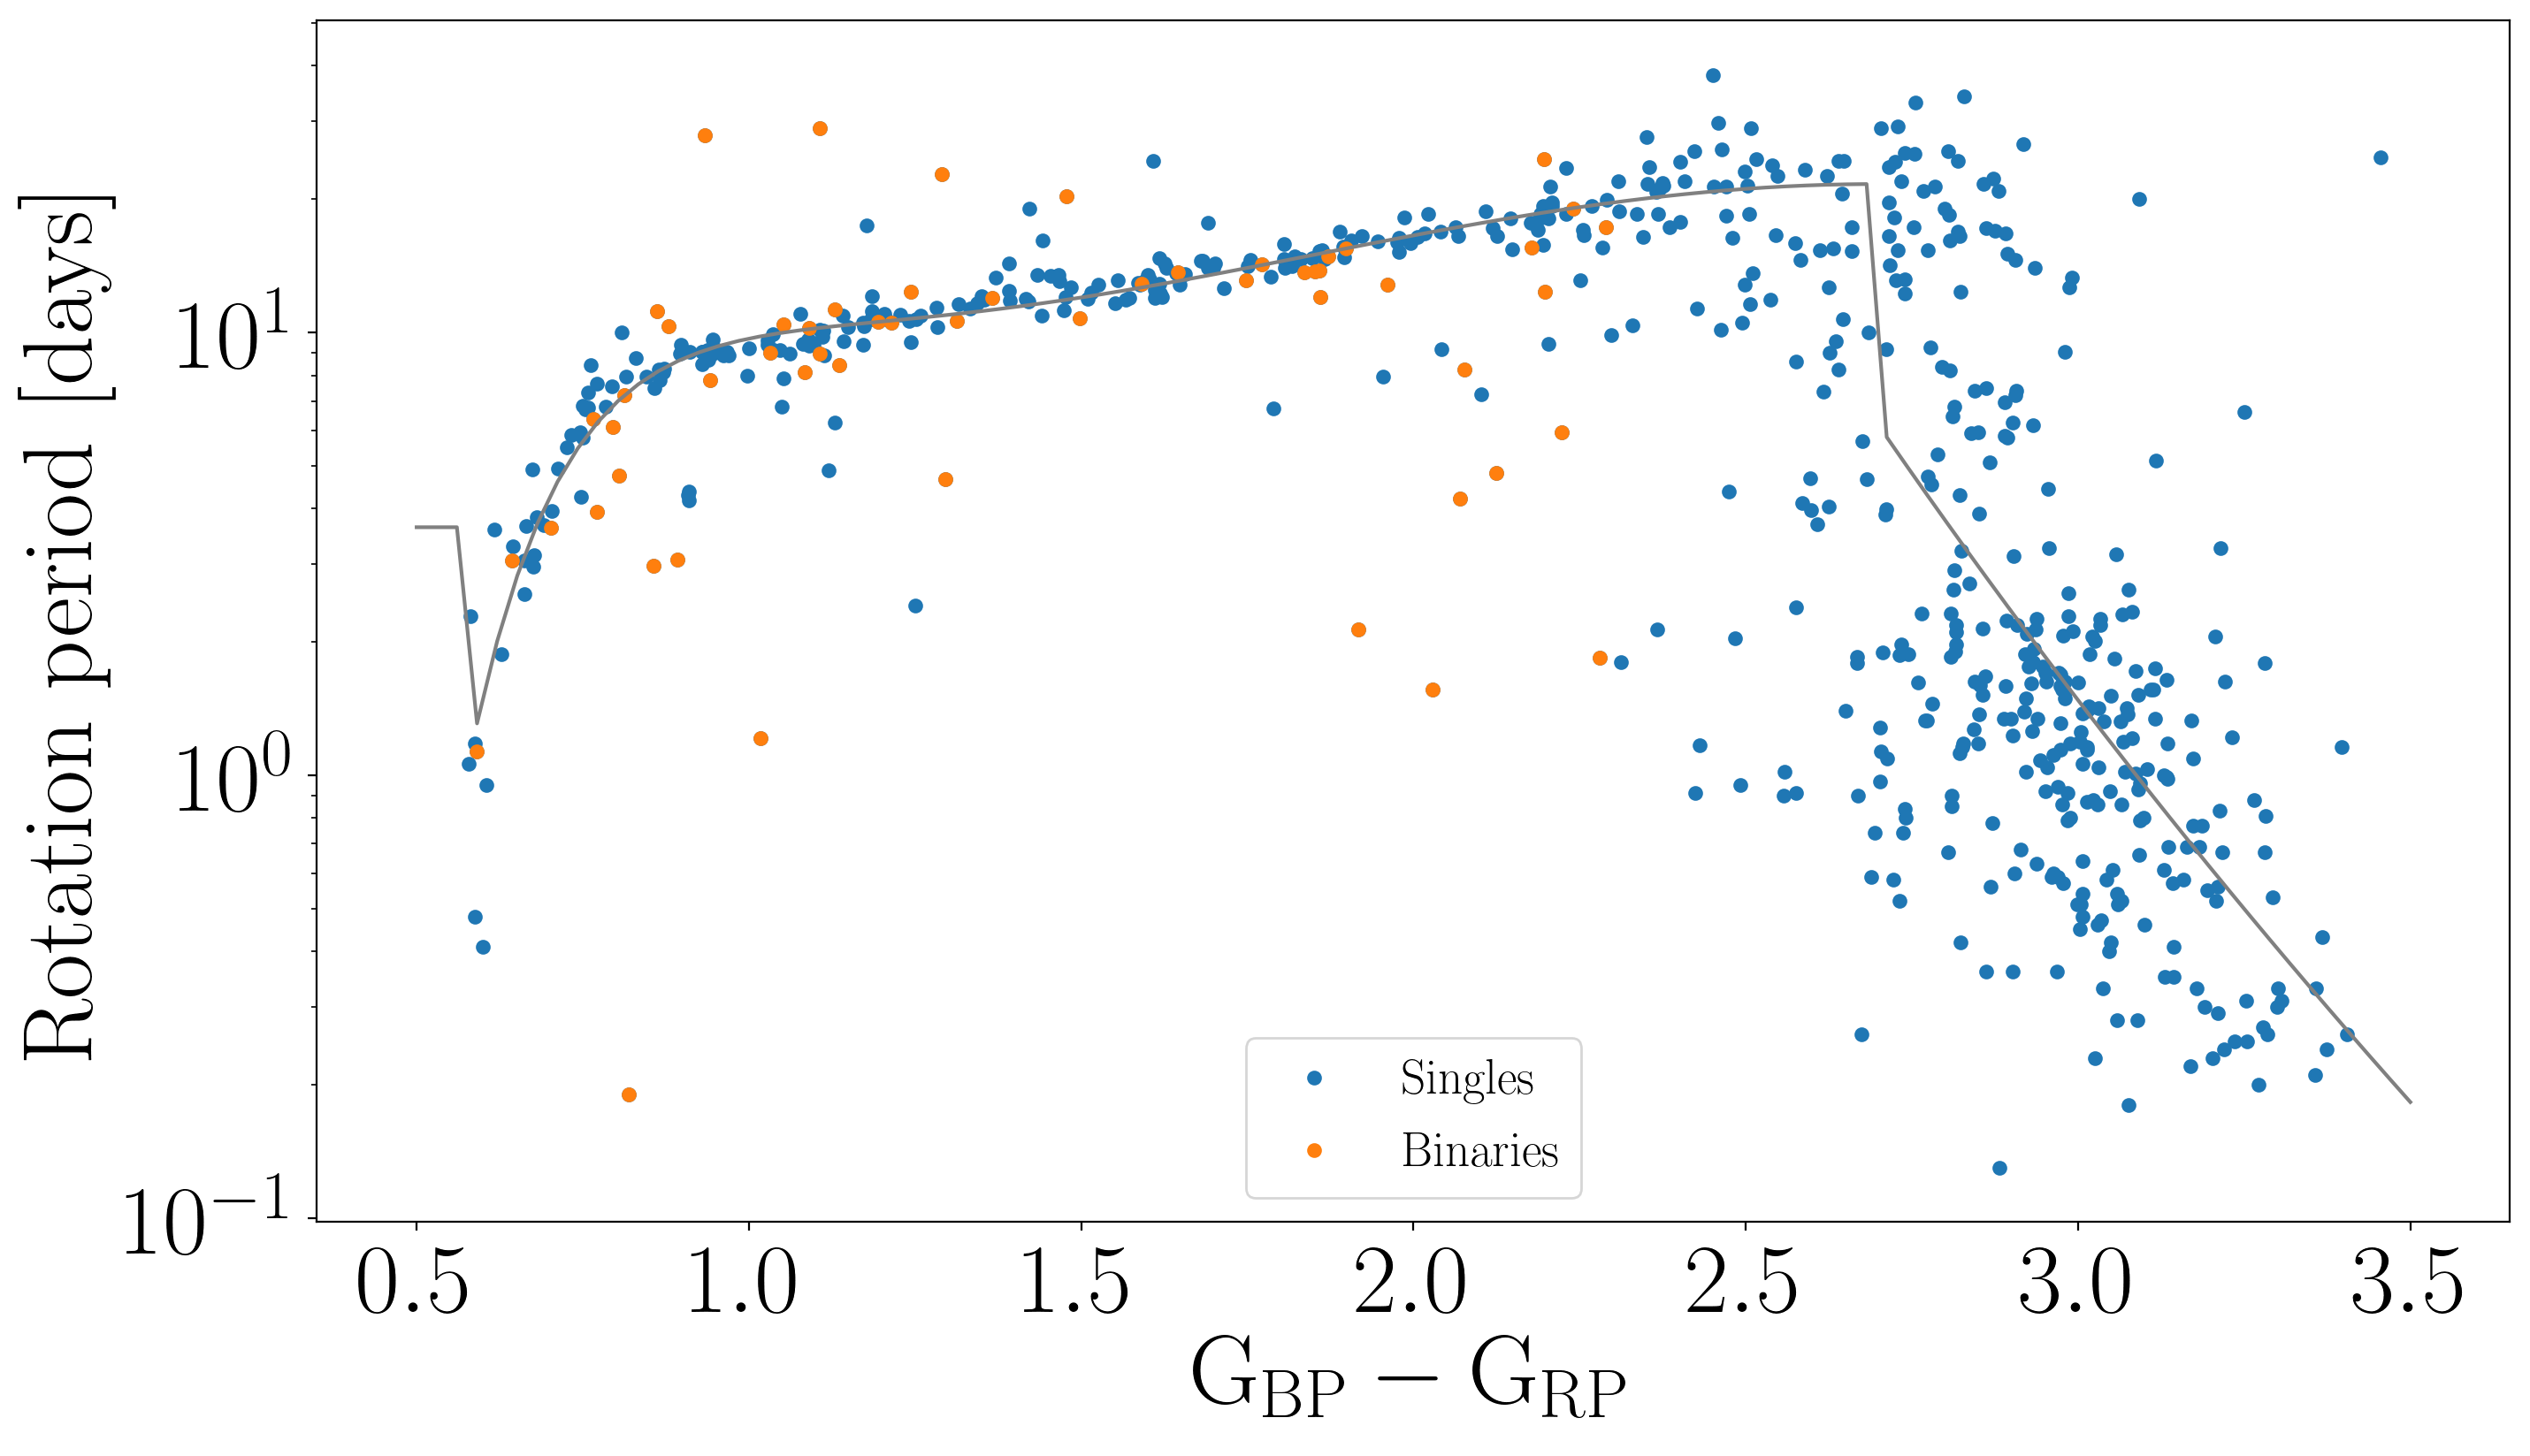

In [41]:
from stardate.lhf import gyro_model_praesepe

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(pr.bp.values-pr.rp.values, pr.prot.values, ".", ms=10, label="$\mathrm{Singles}$")
plt.plot(pr.bp.values[cool][binary_flag == 0]-pr.rp.values[cool][binary_flag == 0],
         pr.prot.values[cool][binary_flag==0], ".", ms=10, label="$\mathrm{Binaries}$")
xs = np.linspace(.5, 3.5, 100)
ps = np.zeros(len(xs))
for i, x in enumerate(xs):
    ps[i] = gyro_model_praesepe(np.log10(650*1e6), x)
    
plt.plot(xs, 10**ps, color=".5", ms=10)
plt.yscale("log")
plt.legend(loc="lower center")

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");